<a href="https://colab.research.google.com/github/josephine-dworkin/capstone-rbf-fd/blob/main/Copy_of_RDF_FD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.sparse import csr_matrix, eye, diags, identity
from scipy.sparse.linalg import spsolve, factorized, LinearOperator, onenormest
from numpy.linalg import solve, cond
from scipy.stats import norm

In [2]:
"""
!pip install chaospy
import chaospy as cp
"""

'\n!pip install chaospy\nimport chaospy as cp\n'

A: Decide node type and RBFs, set initial parameters

In [3]:
K = 375 # strike price
T = 1 # time
r = 0.03
sigma = 0.15
M = 10 ** 6

S_min, S_max = 0.0, 400.0
N = 1000 # number of nodes
m = 7 # stencil size
k = 7 # polyharmonic spline degree
p = 3 # degree of polynomial augmentation
dt = 0.002
Nt = int(T / dt)

B: Node generation and clustering

In [4]:
def uniform_nodes(N, S_min, S_max):
    # generates a simple uniform grid between Smin and Smax.
    return np.linspace(S_min, S_max, N)

def clustered_nodes(N, S_min, S_max, k=4):

  S_uniform = uniform_nodes(N - k + 1, S_min, S_max)
  tree = cKDTree(sorted(S_uniform[:, None]))
  _, cluster = tree.query(K, k)

  cluster_nodes = []
  for i in range(0, k):
    cluster_nodes.append(int(cluster[i]))
  cluster_nodes = sorted(cluster_nodes)

  node_width = S_uniform[2] - S_uniform[1]
  new_nodes = []
  for i in range(cluster_nodes[0], cluster_nodes[k - 1]):
    new_node = S_uniform[i] + (node_width * 0.5)
    new_nodes.append(new_node)

  S_nodes = np.append(S_uniform, new_nodes)
  return S_nodes

def halton_nodes(S_min, S_max, N, burnin=0):
    # generate N Halton samples in [0, 1]
    samples = cp.create_halton_samples(N + burnin, dim=1)
    halton_points = samples[0, burnin:]
    # map to [S_min, S_max]
    S_nodes = S_min + (S_max - S_min) * halton_points
    S_nodes = np.array(S_nodes)
    S_nodes.sort()
    return S_nodes

Node set clustered around strike price

In [5]:
def clustered_strike_nodes(S_min, S_max, K, N, alpha=5.0):
    """
    Clustered 1D nodes for option pricing (RBF-FD style):
    - highest density at strike K
    - lowest density at boundaries
    - exact S_min, S_max

    Parameters
    ----------
    S_min, S_max : float
        Spatial domain bounds
    K : float
        Strike price
    N : int
        Number of nodes
    alpha : float
        Clustering strength (>= 0)

    Returns
    -------
    S : ndarray, shape (N,)
        Clustered spatial nodes
    """

    if not (S_min < K < S_max):
        raise ValueError("K must lie strictly inside (S_min, S_max)")

    xi = np.linspace(0.0, 1.0, N)
    xi_K = (K - S_min) / (S_max - S_min)

    S = np.empty_like(xi)

    # Left of strike
    mask_left = xi <= xi_K
    S[mask_left] = (
        K
        - (K - S_min)
        * np.sinh(alpha * (xi_K - xi[mask_left]) / xi_K)
        / np.sinh(alpha)
    )

    # Right of strike
    mask_right = xi > xi_K
    S[mask_right] = (
        K
        + (S_max - K)
        * np.sinh(alpha * (xi[mask_right] - xi_K) / (1.0 - xi_K))
        / np.sinh(alpha)
    )

    # enforce exact endpoints
    S[0] = S_min
    S[-1] = S_max

    return S


S_nodes = clustered_strike_nodes(S_min, S_max, K, N, alpha=5.0)

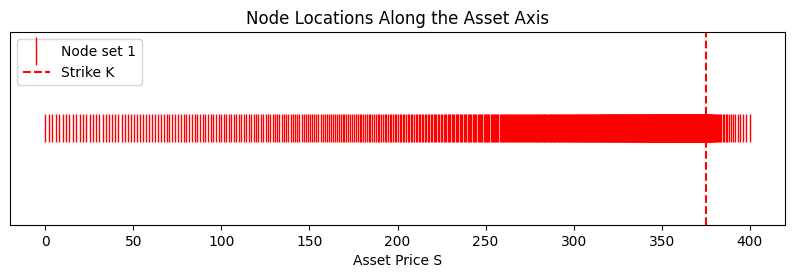

In [6]:
plt.figure(figsize=(10, 2.5))
plt.plot(S_nodes, np.zeros_like(S_nodes), '|', markersize=20, label='Node set 1', color='red')


plt.axvline(K, color='red', linestyle='--', label='Strike K')
plt.xlabel('Asset Price S')
plt.title('Node Locations Along the Asset Axis')
plt.yticks([])
plt.legend()
plt.show()

C: Stencil selection

In [7]:
tree = cKDTree(sorted(S_nodes[:, None]))
_, stencils = tree.query(sorted(S_nodes[:, None]), k=m)

D: Local weight computation (RBF-FD per stencil)

In [8]:
def phs(r, k):
  return np.power(r, k)

def phs_d1(h, k):
  r = np.abs(h)
  return k * h * np.power(r, max(k - 2, 0))

def phs_d2(h, k):
  r = np.abs(h)
  return k * (k - 1) * np.power(r, max(k - 2, 0))

def poly_matrix_1D(x_local, k):
  return np.vstack([x_local ** d for d in range(k + 1)]).T


In [9]:
def build_augmented_matrix_and_rhs(x_local, x_center, k, p,
                                   enforce_constant=True, deriv_order=1):
    # Enforce_constant=False means I do not have an extra unknown/ constraint that enforces
    # the weights to sum to 0. I do not need this extra column because my polynomial augmentation
    # means the matrix includes the constant term "1" as the first column.
    m = x_local.size
    P = poly_matrix_1D(x_local, p)  # (m, p)
    p = P.shape[1]
    c = 1 if enforce_constant else 0

    # Phi matrix
    R = np.abs(x_local[:, None] - x_local[None, :])   # (m,m)
    Phi = phs(R, k)

    # Top-left block is Phi
    # Build top-right polynomial block and optional constant column
    if enforce_constant:
        P_aug = np.hstack([P, np.ones((m,1))])
    else:
        P_aug = P

    # Build bottom block
    bottom_left = P_aug.T
    bottom_right = np.zeros((p + c, p + c))
    # Assemble augmented matrix
    top = np.hstack([Phi, P_aug])
    bottom = np.hstack([bottom_left, bottom_right])
    A_aug = np.vstack([top, bottom])
    # Final augmented matrix has dimensions (m+p+c, m+p+c)

    # Build RHS
    # Top part: operator applied to phi centered at each x_local, evaluated at x_center
    h = x_center - x_local
    if deriv_order == 1:
        rhs_top = np.array([phs_d1(hj, k) for hj in h])
    elif deriv_order == 2:
        rhs_top = np.array([phs_d2(hj, k) for hj in h])
    else:
        raise ValueError("deriv_order must be 1 or 2")

    # Bottom part: derivative of polynomial basis at x_center
    rhs_poly = np.zeros(p + c)
    # For 1D: derivative of x^d is d * x^(d-1)
    if deriv_order == 1:
        for d in range(1, p):
            rhs_poly[d] = d * (x_center ** (d - 1))
        # if constant enforcement present, its RHS bottom entry is 0
    elif deriv_order == 2:
        for d in range(2, p):
            rhs_poly[d] = d * (d-1) * (x_center ** (d - 2))
    rhs = np.concatenate([rhs_top, rhs_poly])

    return A_aug, rhs, m, p, c

for i in range(N):
  idx = stencils[i]
  x_local = S_nodes[idx]
  x_center = S_nodes[i]

w_i = build_augmented_matrix_and_rhs(x_local, x_center, k, p, deriv_order=1)

Compute local weights

In [10]:
def compute_local_weights(x_local, x_center, k, p, enforce_constant=False,
                          deriv_order=1, regularize=1e-13):
  A_aug, rhs, m, p, c = build_augmented_matrix_and_rhs(
      x_local, x_center, k, p, enforce_constant=enforce_constant,
      deriv_order=deriv_order)

  if regularize:
      A_aug = A_aug.copy()
      A_aug[:m, :m] += np.eye(m) * regularize

  sol = solve(A_aug, rhs)
  weights = sol[:m]
  try:
    condA = cond(A_aug)
  except Exception:
    condA = np.inf
  return weights, condA

weights, condA = compute_local_weights(x_local, x_center, k, p, deriv_order=1, regularize=False)

In [11]:
def compute_local_weights_scaled(x_local, x_center, k, p,
                                 enforce_constant=False,
                                 deriv_order=1,
                                 regularize=False):
    # distance from center
    r = np.abs(x_local - x_center)
    # scaling factor: max distance from center
    h = np.max(r)
    # scaled stencil inside [−1, 1]
    x_scaled = (x_local - x_center) / h
    x_center_scaled = 0.0   # set center to zero after scaling

    A_aug, rhs, m, p, c = build_augmented_matrix_and_rhs(
        x_scaled, x_center_scaled, k, p,
        enforce_constant=enforce_constant,
        deriv_order=deriv_order
    )
    # optional Tikhonov regularization
    if regularize:
        A_aug = A_aug.copy()
        A_aug[:m, :m] += np.eye(m) * regularize
    # solve system for scaled derivative
    sol = solve(A_aug, rhs)
    weights_scaled = sol[:m]
    # derivative rescales by h^{-d}
    scale_factor = h**(-deriv_order)
    weights = weights_scaled * scale_factor

    try:
        condA = cond(A_aug)
    except Exception:
        condA = np.inf

    return weights, condA

E: Assemble sparse global spatial operator

In [12]:
def build_global_spatial_matrix(S_nodes_sorted, stencils, k, p, sigma, r,
                                enforce_constant=False, bc_nodes=(0,-1),
                                cond_warn=1e10):
  # bc_nodes sets the indices to treat as Dirichlet rows (the boundary nodes)
  # For my Black-Scholes equations, i need a first derivative matrix,
  # second derivative matrix
  N, m = stencils.shape
  rows, cols, data_D1, data_D2 = [], [], [], []
  rowsA, colsA, dataA = [], [], []

  cond_list = np.zeros(N)

  for i in range(N):
    idx = stencils[i]
    x_local = S_nodes_sorted[idx]
    x_center = S_nodes_sorted[i]
    Si = x_center

    # enforce_constant=True here leads to incredibly large condition numbers/ singular matrices. would be good to understand exactly why this is the case
    w1, cond1 = compute_local_weights_scaled(x_local, x_center,
                                      k, p, enforce_constant=False, deriv_order=1)
    w2, cond2 = compute_local_weights_scaled(x_local, x_center,
                                      k, p, enforce_constant=False, deriv_order=2)

    cond_list[i] = max(cond1, cond2)

    if cond_list[i] > cond_warn:
      print(f"stencil {[i]} cond ~ {cond_list[i]:.2e}")

    for local_j, j in enumerate(idx):
      # store D1 and D2 entries
      rows.append(i); cols.append(j)
      data_D1.append(w1[local_j])
      data_D2.append(w2[local_j])

      # Black–Scholes operator entry
      A_ij = 0.5 * (sigma ** 2) * (Si ** 2) * w2[local_j] + r * Si * w1[local_j]
      rowsA.append(i); colsA.append(j); dataA.append(A_ij)

    rowsA.append(i);colsA.append(i);dataA.append(-r)

  D1 = csr_matrix((data_D1, (rows, cols)), shape=(N, N))
  D2 = csr_matrix((data_D2, (rows, cols)), shape=(N, N))
  A = csr_matrix((dataA, (rowsA, colsA)), shape=(N, N))

  return D1.tocsr(), D2.tocsr(), A.tocsr(), cond_list

D1, D2, A_spatial, cond_local = build_global_spatial_matrix(S_nodes, stencils, k, p, sigma, r, enforce_constant=False, bc_nodes=(0,-1))


Boundaries

In [13]:
def boundary_values_call_1d(S_nodes, t, T, r, K):
   # Dirichlet bc for 1D European call at time t as:
   # lower: u(t, 0) = 0
   # uppoer: u(S_max, t) = S_max - K * exp(-r * (T - t))
   # function returns a vector g of length N with NaN for interior nodes and numeric BC values at boundaries
   # so that the solver caller can place them

   N = S_nodes.size
   g = np.full(N, np.nan)
   g[0] = 0.0
   S_max = S_nodes[-1]
   g[-1] = S_max = K * np.exp(-r * (T - t))

   return g

def enforce_dirichlet_rows(A, rhs, bc_idx, bc_vals):
    """
    Robustly replace rows in sparse matrix A with identity rows
    and set rhs entries to bc_vals.

    A : scipy.sparse.csr_matrix
    rhs : numpy array
    bc_idx : iterable of integer row indices (e.g. [0, N-1])
    bc_vals : iterable of corresponding boundary values
    Returns A (csr) and rhs modified.
    """
    # Work on LIL for safe row replacement
    A_lil = A.tolil()

    for b_idx, b_val in zip(bc_idx, bc_vals):
        # set row to single diagonal 1.0
        A_lil.rows[b_idx] = [b_idx]
        A_lil.data[b_idx] = [1.0]
        # set RHS
        rhs[b_idx] = b_val

    # back to CSR
    A = A_lil.tocsr()

    return A, rhs

Estimate condition number

In [14]:
"""
def condest_1norm_safe(A):
    from scipy.sparse.linalg import onenormest, LinearOperator, factorized
    # Estimate ||A||_1
    Aop = LinearOperator(A.shape, matvec=lambda v: A.dot(v))
    normA = onenormest(Aop)
    # Build solver (try factorized for speed)
    try:
        solve_fn = factorized(A.tocsc())
        Ainv_op = LinearOperator(A.shape, matvec=lambda v: solve_fn(v))
        normAinv = onenormest(Ainv_op)
    except Exception:
        # fallback: use spsolve inside LinearOperator (slower but robust)
        Ainv_op = LinearOperator(A.shape, matvec=lambda v: spsolve(A, v))
        normAinv = onenormest(Ainv_op)
    return normA * normAinv
"""

'\ndef condest_1norm_safe(A):\n    from scipy.sparse.linalg import onenormest, LinearOperator, factorized\n    # Estimate ||A||_1\n    Aop = LinearOperator(A.shape, matvec=lambda v: A.dot(v))\n    normA = onenormest(Aop)\n    # Build solver (try factorized for speed)\n    try:\n        solve_fn = factorized(A.tocsc())\n        Ainv_op = LinearOperator(A.shape, matvec=lambda v: solve_fn(v))\n        normAinv = onenormest(Ainv_op)\n    except Exception:\n        # fallback: use spsolve inside LinearOperator (slower but robust)\n        Ainv_op = LinearOperator(A.shape, matvec=lambda v: spsolve(A, v))\n        normAinv = onenormest(Ainv_op)\n    return normA * normAinv\n'

Checks for condest_1norm_safe

In [15]:
"""
import scipy.sparse.linalg as spla
import inspect

print("onenormest:", spla.onenormest, type(spla.onenormest))
print("LinearOperator:", spla.LinearOperator, type(spla.LinearOperator))
print("splu:", spla.splu, type(spla.splu))
print("spsolve:", spla.spsolve, type(spla.spsolve))

print("\nLocal names:")
print("onenormest:", onenormest, type(onenormest))
print("LinearOperator:", LinearOperator, type(LinearOperator))
print("spsolve:", spsolve, type(spsolve))
"""

'\nimport scipy.sparse.linalg as spla\nimport inspect\n\nprint("onenormest:", spla.onenormest, type(spla.onenormest))\nprint("LinearOperator:", spla.LinearOperator, type(spla.LinearOperator))\nprint("splu:", spla.splu, type(spla.splu))\nprint("spsolve:", spla.spsolve, type(spla.spsolve))\n\nprint("\nLocal names:")\nprint("onenormest:", onenormest, type(onenormest))\nprint("LinearOperator:", LinearOperator, type(LinearOperator))\nprint("spsolve:", spsolve, type(spsolve))\n'

In [16]:
"""
def condest_1norm_safe(A):
    from scipy.sparse.linalg import onenormest, LinearOperator, splu, spsolve

    # ||A||_1
    Aop = LinearOperator(A.shape, matvec=A.dot)
    normA = onenormest(Aop)

    # ||A^{-1}||_1
    try:
        # Explicit LU (more reliable than factorized)
        lu = splu(A.tocsc())

        def solve_lu(v):
            return lu.solve(v)

        Ainv_op = LinearOperator(A.shape, matvec=solve_lu)
        normAinv = onenormest(Ainv_op)

    except Exception as e:
        print("LU failed in condest, falling back to spsolve:", e)

        Ainv_op = LinearOperator(
            A.shape,
            matvec=lambda v: spsolve(A, v)
        )
        normAinv = onenormest(Ainv_op)

    return normA * normAinv
"""

'\ndef condest_1norm_safe(A):\n    from scipy.sparse.linalg import onenormest, LinearOperator, splu, spsolve\n\n    # ||A||_1\n    Aop = LinearOperator(A.shape, matvec=A.dot)\n    normA = onenormest(Aop)\n\n    # ||A^{-1}||_1\n    try:\n        # Explicit LU (more reliable than factorized)\n        lu = splu(A.tocsc())\n\n        def solve_lu(v):\n            return lu.solve(v)\n\n        Ainv_op = LinearOperator(A.shape, matvec=solve_lu)\n        normAinv = onenormest(Ainv_op)\n\n    except Exception as e:\n        print("LU failed in condest, falling back to spsolve:", e)\n\n        Ainv_op = LinearOperator(\n            A.shape,\n            matvec=lambda v: spsolve(A, v)\n        )\n        normAinv = onenormest(Ainv_op)\n\n    return normA * normAinv\n'

In [17]:
def condest_1norm_safe(A):
    """
    1-norm condition number estimate for sparse matrices.
    A must be sparse.
    """
    # ||A||_1
    Aop = spla.LinearOperator(A.shape, matvec=A.dot)
    normA = spla.onenormest(Aop)

    # ||A^{-1}||_1
    try:
        lu = spla.splu(A.tocsc())

        def solve_lu(v):
            return lu.solve(v)

        Ainv_op = spla.LinearOperator(A.shape, matvec=solve_lu)
        normAinv = spla.onenormest(Ainv_op)

    except Exception as e:
        print("LU failed, fallback to spsolve:", e)
        Ainv_op = spla.LinearOperator(
            A.shape,
            matvec=lambda v: spla.spsolve(A, v)
        )
        normAinv = spla.onenormest(Ainv_op)

    return normA * normAinv

A_test = sp.eye(10, format="csr")

In [18]:
from scipy.sparse.linalg import eigs

def cond_spectral(A, k=1):
  lam_max = eigs(A, k=k, which="LM", return_eigenvectors=False)
  lam_min = eigs(A, k=k, which="SM", return_eigenvectors=False)
  return abs(lam_max[0])/abs(lam_min[0])

F: Time discretization using Crank-Nicolson (?)

In [19]:
"""
def solve_crank_nicolson(
    S_nodes, stencils, k, p,
    sigma, r, K, T, dt,
    enforce_constant=False,
    bc_nodes=(0, -1),
    cond_warn=1e10,
    verbose=True
):
    N = S_nodes.size
    Nt = int(np.ceil(T / dt))

    # ---- build spatial operator ONCE ----
    D1, D2, A_spatial, cond_local = build_global_spatial_matrix(
        S_nodes, stencils, k, p, sigma, r,
        enforce_constant=False,
        bc_nodes=None
    )

    I = identity(N, format="csr")
    A_left_base  = I - 0.5 * dt * A_spatial
    A_right      = I + 0.5 * dt * A_spatial

    # terminal condition
    Vn = np.maximum(S_nodes - K, 0.0)

    # boundary indices
    bc_idx = [(b if b >= 0 else N + b) for b in bc_nodes]

    if verbose:
        print(f"Crank–Nicolson: Nt={Nt}, dt={dt}")

    # ---- time stepping ----
    for n in range(Nt):
        t_next = T - (n + 1) * dt

        # RHS
        rhs = A_right @ Vn

        # boundary values
        g = boundary_values_call_1d(S_nodes, t_next, T, r, K)
        bc_vals = [g[i] for i in bc_idx]

        # enforce BCs on LHS and RHS
        A_left, rhs = enforce_dirichlet_rows(
            A_left_base.copy(), rhs, bc_idx, bc_vals
        )

        # solve
        Vn = spsolve(A_left, rhs)

    # solution at t=0
    V0 = Vn

    # Greeks
    Delta = D1 @ V0
    Gamma = D2 @ V0
    Theta = -A_spatial @ V0

    # condition number estimate
    try:
        cond_left = condest_1norm_safe(A_left)
    except Exception:
        cond_left = np.inf

    cond_left = cond_spectral(A_left)

    return {
        "V0": V0,
        "Delta": Delta,
        "Gamma": Gamma,
        "Theta": Theta,
        "cond_local": cond_local,
        "cond_left_est": cond_left
    }

Global_condition_number = solve_crank_nicolson(S_nodes, stencils, k, p,
                                               sigma, r, K, T, dt,
                                               enforce_constant=False,
                                               bc_nodes=(0,-1), cond_warn=1e10,
                                               verbose=True)["cond_left_est"]

print(Global_condition_number)

Delta = solve_crank_nicolson(S_nodes, stencils, k, p,
                                               sigma, r, K, T, dt,
                                               enforce_constant=False,
                                               bc_nodes=(0,-1), cond_warn=1e10,
                                               verbose=True)["Delta"]

Gamma = solve_crank_nicolson(S_nodes, stencils, k, p,
                                               sigma, r, K, T, dt,
                                               enforce_constant=False,
                                               bc_nodes=(0,-1), cond_warn=1e10,
                                               verbose=True)["Gamma"]

Theta = solve_crank_nicolson(S_nodes, stencils, k, p,
                                               sigma, r, K, T, dt,
                                               enforce_constant=False,
                                               bc_nodes=(0,-1), cond_warn=1e10,
                                               verbose=True)["Theta"]
"""

'\ndef solve_crank_nicolson(\n    S_nodes, stencils, k, p,\n    sigma, r, K, T, dt, \n    enforce_constant=False,\n    bc_nodes=(0, -1),\n    cond_warn=1e10,\n    verbose=True\n):\n    N = S_nodes.size\n    Nt = int(np.ceil(T / dt))\n\n    # ---- build spatial operator ONCE ----\n    D1, D2, A_spatial, cond_local = build_global_spatial_matrix(\n        S_nodes, stencils, k, p, sigma, r,\n        enforce_constant=False,\n        bc_nodes=None\n    )\n\n    I = identity(N, format="csr")\n    A_left_base  = I - 0.5 * dt * A_spatial\n    A_right      = I + 0.5 * dt * A_spatial\n\n    # terminal condition\n    Vn = np.maximum(S_nodes - K, 0.0)\n\n    # boundary indices\n    bc_idx = [(b if b >= 0 else N + b) for b in bc_nodes]\n\n    if verbose:\n        print(f"Crank–Nicolson: Nt={Nt}, dt={dt}")\n\n    # ---- time stepping ----\n    for n in range(Nt):\n        t_next = T - (n + 1) * dt\n\n        # RHS\n        rhs = A_right @ Vn\n\n        # boundary values\n        g = boundary_values_c

In [20]:
def solve_crank_nicolson(
    S_nodes, stencils, k, p,
    sigma, r, K, T, dt,
    enforce_constant=False,
    bc_nodes=(0, -1),
    cond_warn=1e10,
    verbose=True
):
    N = S_nodes.size
    Nt = int(np.ceil(T / dt))

    # ---- build spatial operator ONCE ----
    D1, D2, A_spatial, cond_local = build_global_spatial_matrix(
        S_nodes, stencils, k, p, sigma, r,
        enforce_constant=False,
        bc_nodes=None
    )

    I = identity(N, format="csr")
    A_left_base  = I - 0.5 * dt * A_spatial
    A_right      = I + 0.5 * dt * A_spatial

    # terminal condition
    Vn = np.maximum(S_nodes - K, 0.0)

    # boundary indices
    bc_idx = [(b if b >= 0 else N + b) for b in bc_nodes]

    if verbose:
        print(f"Crank–Nicolson: Nt={Nt}, dt={dt}")

    # ---- time stepping ----
    for n in range(Nt):
        t_next = T - (n + 1) * dt

        # RHS
        rhs = A_right @ Vn

        # boundary values
        g = boundary_values_call_1d(S_nodes, t_next, T, r, K)
        bc_vals = [g[i] for i in bc_idx]

        # enforce BCs on LHS and RHS
        A_left, rhs = enforce_dirichlet_rows(
            A_left_base.copy(), rhs, bc_idx, bc_vals
        )

        # solve
        Vn = spsolve(A_left, rhs)

    # solution at t=0
    V0 = Vn

    # Greeks
    Delta = D1 @ V0
    Gamma = D2 @ V0
    Theta = -A_spatial @ V0

    return {
        "V0": V0,
        "Delta": Delta,
        "Gamma": Gamma,
        "Theta": Theta,
        "cond_local": cond_local,
    }

delta_cn = solve_crank_nicolson(S_nodes, stencils, k, p,
                                               sigma, r, K, T, dt,
                                               enforce_constant=False,
                                               bc_nodes=(0,-1), cond_warn=1e10,
                                               verbose=True)["Delta"]

gamma_cn = solve_crank_nicolson(S_nodes, stencils, k, p,
                                               sigma, r, K, T, dt,
                                               enforce_constant=False,
                                               bc_nodes=(0,-1), cond_warn=1e10,
                                               verbose=True)["Gamma"]

theta_cn = solve_crank_nicolson(S_nodes, stencils, k, p,
                                               sigma, r, K, T, dt,
                                               enforce_constant=False,
                                               bc_nodes=(0,-1), cond_warn=1e10,
                                               verbose=True)["Theta"]

Crank–Nicolson: Nt=500, dt=0.002
Crank–Nicolson: Nt=500, dt=0.002
Crank–Nicolson: Nt=500, dt=0.002


Time Discretization using BDF-2

In [21]:
def solve_bdf2(
    S_nodes, stencils, k, p,
    sigma, r, K, T, dt,
    enforce_constant=False,
    bc_nodes=(0, -1),
    cond_warn=1e10,
    verbose=True
):
    """
    RBF-FD in space + BDF2 in time for 1D Black–Scholes.
    Time stepping follows Milovanović & von Sydow (2017),
    with backward Euler startup.
    """

    N = S_nodes.size
    Nt = int(np.ceil(T / dt))

    # ---- build spatial operator ONCE ----
    D1, D2, A_spatial, cond_local = build_global_spatial_matrix(
        S_nodes, stencils, k, p, sigma, r,
        enforce_constant=False,
        bc_nodes=None
    )

    I = identity(N, format="csr")

    # terminal condition (payoff)
    V0_term = np.maximum(S_nodes - K, 0.0)

    # boundary indices
    bc_idx = [(b if b >= 0 else N + b) for b in bc_nodes]

    if verbose:
        print(f"BDF-2: Nt={Nt}, dt={dt} (Backward Euler startup)")

    # ============================================================
    # Step 1: Backward Euler to compute V^{1}
    # ============================================================
    BE_left = (I / dt - A_spatial).tocsr()
    rhs_BE = V0_term / dt

    t1 = T - dt
    g1 = boundary_values_call_1d(S_nodes, t1, T, r, K)
    bc_vals1 = [g1[i] for i in bc_idx]

    BE_left, rhs_BE = enforce_dirichlet_rows(
        BE_left.copy(), rhs_BE, bc_idx, bc_vals1
    )

    V_prev = V0_term.copy()   # V^0
    V_curr = spsolve(BE_left, rhs_BE)  # V^1

    # ============================================================
    # Step 2+: BDF-2 time stepping
    # ============================================================
    BDF2_left_base = (3.0 / (2.0 * dt)) * I - A_spatial
    BDF2_left_base = BDF2_left_base.tocsr()

    for n in range(1, Nt):
        t_next = T - (n + 1) * dt

        rhs = (
            (4.0 / (2.0 * dt)) * V_curr
            - (1.0 / (2.0 * dt)) * V_prev
        )

        g = boundary_values_call_1d(S_nodes, t_next, T, r, K)
        bc_vals = [g[i] for i in bc_idx]

        BDF2_left, rhs = enforce_dirichlet_rows(
            BDF2_left_base.copy(), rhs, bc_idx, bc_vals
        )

        V_next = spsolve(BDF2_left, rhs)

        V_prev[:] = V_curr
        V_curr[:] = V_next

    # solution at t = 0
    V0 = V_curr

    # ============================================================
    # Greeks
    # ============================================================
    Delta = D1 @ V0
    Gamma = D2 @ V0

    # Theta from PDE:  V_t = A V   →   Theta = -V_t
    Theta = -A_spatial @ V0

    # ============================================================
    # Condition number estimate (same philosophy as CN)
    # ============================================================
    try:
        cond_left = condest_1norm_safe(BDF2_left)
    except Exception:
        cond_left = np.inf

    cond_left = cond_spectral(BDF2_left)

    return {
        "V0": V0,
        "Delta": Delta,
        "Gamma": Gamma,
        "Theta": Theta,
        "cond_local": cond_local,
        "cond_left_est": cond_left
    }


In [22]:
global_condition_number = solve_bdf2(S_nodes, stencils, k, p,
                                               sigma, r, K, T, dt,
                                               enforce_constant=False,
                                               bc_nodes=(0,-1), cond_warn=1e10,
                                               verbose=True)["cond_left_est"]

print(global_condition_number)

V0 = solve_bdf2(S_nodes, stencils, k, p,
                                               sigma, r, K, T, dt,
                                               enforce_constant=False,
                                               bc_nodes=(0,-1), cond_warn=1e10,
                                               verbose=True)["V0"]

delta_bdf = solve_bdf2(S_nodes, stencils, k, p,
                                               sigma, r, K, T, dt,
                                               enforce_constant=False,
                                               bc_nodes=(0,-1), cond_warn=1e10,
                                               verbose=True)["Delta"]

gamma_bdf = solve_bdf2(S_nodes, stencils, k, p,
                                               sigma, r, K, T, dt,
                                               enforce_constant=False,
                                               bc_nodes=(0,-1), cond_warn=1e10,
                                               verbose=True)["Gamma"]

theta_bdf = solve_bdf2(S_nodes, stencils, k, p,
                                               sigma, r, K, T, dt,
                                               enforce_constant=False,
                                               bc_nodes=(0,-1), cond_warn=1e10,
                                               verbose=True)["Theta"]


BDF-2: Nt=500, dt=0.002 (Backward Euler startup)
15854339.343168236
BDF-2: Nt=500, dt=0.002 (Backward Euler startup)
BDF-2: Nt=500, dt=0.002 (Backward Euler startup)
BDF-2: Nt=500, dt=0.002 (Backward Euler startup)
BDF-2: Nt=500, dt=0.002 (Backward Euler startup)


G: Diagnostics and parameter tuning

In [23]:
# plt.plot(S_nodes, delta_bdf)
# plt.axvline(K, color='r', linestyle='--')
# plt.title("Delta vs S")
# plt.xlabel("S")
# plt.ylabel("Delta")
# plt.show()

# plt.plot(S_nodes, gamma_bdf)
# plt.axvline(K, color='r', linestyle='--')
# plt.title("Gamma vs S")
# plt.xlabel("S")
# plt.ylabel("Gamma")
# plt.show()

# plt.plot(S_nodes, theta_bdf)
# plt.axvline(K, color='r', linestyle='--')
# plt.title("Theta vs S")
# plt.xlabel("S")
# plt.ylabel("Theta")
# plt.show()


H: Confervence tests and error analysis

Generating analytic solutions

In [24]:
def black_scholes_exact(S, K, T, t, r, sigma, option="call"):
    S = np.asarray(S, dtype=float)
    tau = np.maximum(T - t, 1e-14)  # avoid division by zero

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)

    if option == "call":
        V = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    elif option == "put":
        V = K * np.exp(-r * tau) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option must be 'call' or 'put'")

    return V

def delta_exact(S, K, T, t, r, sigma, option="call"):
    S = np.asarray(S, dtype=float)
    tau = np.maximum(T - t, 1e-14)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))

    if option == "call":
        return norm.cdf(d1)
    else:
        return norm.cdf(d1) - 1

def gamma_exact(S, K, T, t, r, sigma):
    S = np.asarray(S, dtype=float)
    tau = np.maximum(T - t, 1e-14)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))

    return norm.pdf(d1) / (S * sigma * np.sqrt(tau))

def theta_exact(S, K, T, t, r, sigma, option="call"):
    S = np.asarray(S, dtype=float)
    tau = np.maximum(T - t, 1e-14)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)

    term1 = - (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(tau))

    if option == "call":
        term2 = - r * K * np.exp(-r * tau) * norm.cdf(d2)
    else:
        term2 = + r * K * np.exp(-r * tau) * norm.cdf(-d2)

    return term1 + term2


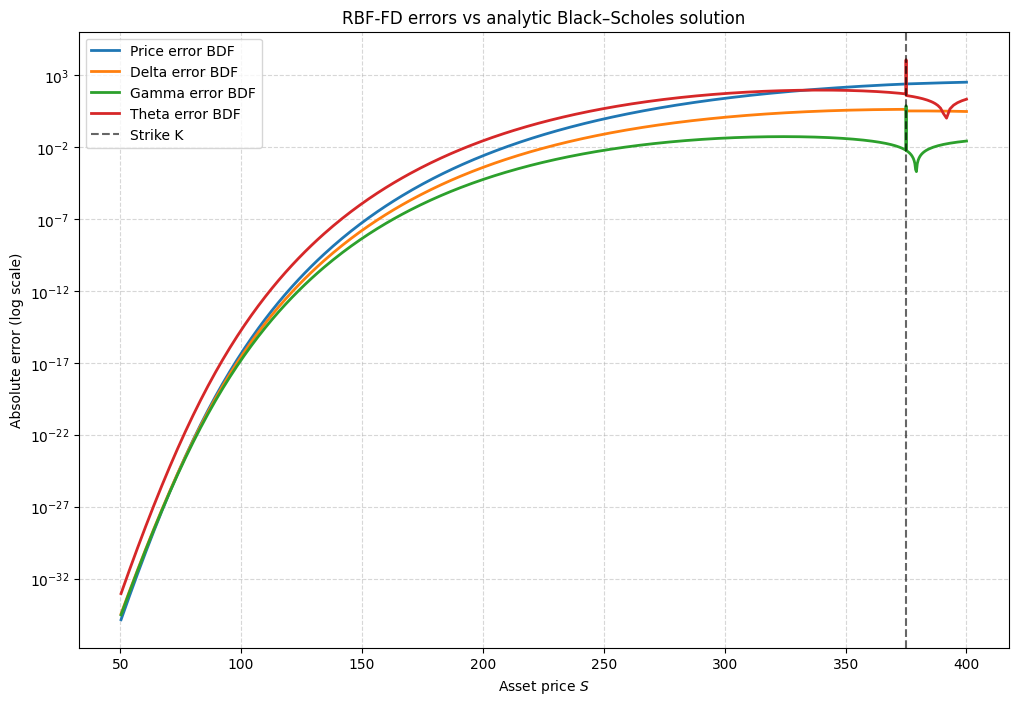

In [25]:
eps = 1e-8
t_eval = T - eps

mask = S_nodes > 50
S_safe = S_nodes[mask]

S_eval     = S_nodes[mask]
V_num      = V0[mask]
Delta_num  = delta_bdf[mask]
Gamma_num  = gamma_bdf[mask]
Theta_num  = theta_bdf[mask]

V_exact      = black_scholes_exact(S_eval, K, T, t_eval, r, sigma)
Delta_analytic  = delta_exact(S_eval, K, T, t_eval, r, sigma)
Gamma_analytic  = gamma_exact(S_eval, K, T, t_eval, r, sigma)
Theta_analytic  = theta_exact(S_eval, K, T, t_eval, r, sigma)

price_error_bdf     = np.abs(V_num     - V_exact)
delta_error_bdf = np.abs(Delta_num - Delta_analytic)
gamma_error_bdf = np.abs(Gamma_num - Gamma_analytic)
theta_error_bdf = np.abs(Theta_num - Theta_analytic)

V_num_cn = V0[mask]
Delta_num_cn  = delta_cn[mask]
Gamma_num_cn  = gamma_cn[mask]
Theta_num_cn  = theta_cn[mask]

price_error_cn     = np.abs(V_num_cn     - V_exact)
delta_error_cn = np.abs(Delta_num_cn - Delta_analytic)
gamma_error_cn = np.abs(Gamma_num_cn - Gamma_analytic)
theta_error_cn = np.abs(Theta_num_cn - Theta_analytic)

plt.figure(figsize=(12, 8))

plt.semilogy(S_eval, price_error_bdf, label="Price error BDF", linewidth=2)
plt.semilogy(S_eval, delta_error_bdf, label="Delta error BDF", linewidth=2)
plt.semilogy(S_eval, gamma_error_bdf, label="Gamma error BDF", linewidth=2)
plt.semilogy(S_eval, theta_error_bdf, label="Theta error BDF", linewidth=2)

plt.axvline(K, color="k", linestyle="--", alpha=0.6, label="Strike K")

plt.xlabel("Asset price $S$")
plt.ylabel("Absolute error (log scale)")
plt.title("RBF-FD errors vs analytic Black–Scholes solution")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)

plt.show()



Condition numbers

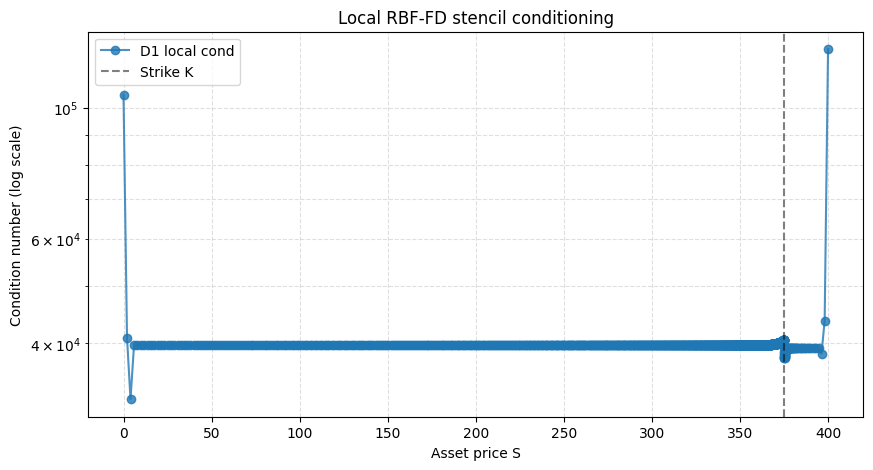

In [26]:
def collect_local_condition_numbers(S_nodes, stencils, k, p):
    N = S_nodes.size
    cond_d1 = np.zeros(N)
    cond_d2 = np.zeros(N)

    for i in range(N):
        idx = stencils[i]
        x_local = S_nodes[idx]
        x_center = S_nodes[i]

        _, cond1 = compute_local_weights_scaled(
            x_local, x_center, k, p, deriv_order=1
        )
        _, cond2 = compute_local_weights_scaled(
            x_local, x_center, k, p, deriv_order=2
        )

        cond_d1[i] = cond1
        cond_d2[i] = cond2

    return cond_d1, cond_d2

cond_d1, cond_d2 = collect_local_condition_numbers(S_nodes, stencils, k, p)

plt.figure(figsize=(10, 5))
plt.semilogy(S_nodes, cond_d1, 'o-', label="D1 local cond", alpha=0.8)
# plt.semilogy(S_nodes, cond_d2, 's-', label="D2 local cond", alpha=0.8)

plt.axvline(K, color='k', linestyle='--', alpha=0.5, label="Strike K")

plt.xlabel("Asset price S")
plt.ylabel("Condition number (log scale)")
plt.title("Local RBF-FD stencil conditioning")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.show()



In [27]:
I = sp.identity(N, format="csr")
A_left_cond = I - 0.5 * dt * A_spatial

print(condest_1norm_safe(I))

TypeError: 'NoneType' object is not callable

Numerical Experiment: How does conditioning scale with N?

In [ ]:
Ns = [50, 75, 100, 150, 200]
cond_global = []

for N_test in Ns:
    S_nodes = clustered_strike_nodes(S_min, S_max, K, N_test)
    tree = cKDTree(S_nodes[:, None])
    _, stencils = tree.query(S_nodes[:, None], k=m)

    _, _, A_test, _ = build_global_spatial_matrix(
        S_nodes, stencils, k, p, sigma, r
    )

    I = sp.identity(N_test)
    A_left = I - 0.5 * dt * A_test
    cond_global.append(cond_spectral(A_left_cond))

plt.figure(figsize=(7,5))
plt.loglog(Ns, cond_global, 'o-')
plt.xlabel("Number of nodes N")
plt.ylabel("Condition number estimate")
plt.title("Global matrix conditioning vs resolution")
plt.grid(True, which="both")
plt.show()


apply method to increaes N. try and see what it does

Testing for various N

In [ ]:
def solver_cn(S_nodes, stencils, k, p, sigma, r, K, T, dt, enforce_constant=False, bc_nodes=(0,1), cond_warn=1e10):
  V0_cn, Delta_cn, Gamma_cn, Theta_cn, cond_local_cn = solve_crank_nicolson(
    S_nodes, stencils, k, p,
    sigma, r, K, T, dt,
    enforce_constant=False,
    bc_nodes=(0, -1),
    cond_warn=1e10,
    verbose=True
  )
  return {
        "V0": V0_cn,
        "Delta": Delta_cn,
        "Gamma": Gamma_cn,
        "Theta": Theta_cn,
        "cond_local": cond_local_cn
    }

print(solver_cn(S_nodes, stencils, k, p, sigma, r, K, T, dt, enforce_constant=False, bc_nodes=(0,1), cond_warn=1e10))